In [258]:
import pyhere
import sys
sys.path.insert(0, str(pyhere.here().resolve().joinpath("src")))
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor


primary_fuel_transformed
Other                       18917
Solar                       10665
Wind                         5344
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

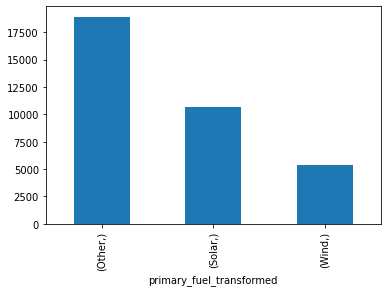

In [259]:
csv_power_plants = pd.read_csv(utils.DIR_DATA_INTERIM/"power_plants_with_generation_transformed.csv", index_col=[0])
# df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v2_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v5_transformed_data_combined_with_nasa.csv", index_col=['index'])
# csv_power_plants.loc[0:34935, ['capacity_mw', 'primary_fuel_transformed']].index.name = "index"
csv_power_plants.index.rename('index', inplace=True)
df_power_plants_raw = pd.read_csv(utils.DIR_DATA_RAW/"global_power_plant_database.csv", usecols=['name','primary_fuel', 'estimated_generation_gwh_2013'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

# index_set_to_delete = csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])].index.tolist()
# index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])].index.tolist())
# index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])].index.tolist())

# csv_power_plants.drop(index_set_to_delete, inplace = True)
columns_to_combine = [
                        'name',
                        'capacity_mw',
                        'primary_fuel_transformed',
                        # 'other_fuel1',
                        # 'other_fuel2',
                        # 'other_fuel3',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'estimated_generation_gwh_2013',
                        # 'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:24360, ['capacity_mw', 'primary_fuel_transformed']],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [260]:
df_solar = df_transformed_combined[df_transformed_combined['primary_fuel_transformed']== "Solar"]
df_solar = df_solar[~df_solar['name'].str.contains('CSP')]
df_solar

latitude  longitude  ANN_ALLSKY_SFC_LW_DWN_2013  \
index                                                    
1        31.670     65.795                      315.48   
2        31.623     65.792                      315.48   
17       27.908     -0.317                      355.96   
18       35.880      5.475                      323.29   
20       34.532      0.804                      317.57   
...         ...        ...                         ...   
34833    11.700    108.900                      385.23   
34847    11.446    108.866                      385.23   
34894    16.440    107.505                      419.30   
34895    11.700    109.030                      416.33   
34921   -15.550     28.350                      353.47   

       ANN_ALLSKY_SFC_LW_DWN_2014  ANN_ALLSKY_SFC_LW_DWN_2015  \
index                                                           
1                          312.10                      318.59   
2                          312.10                      318.59   
17                         359.55                      360.83   
18                         325.23                      325.22   
20                         321.81                      321.93   
...                           ...                         ...   
34833                      383.91                      383.59   
34847                      383.91                      383.59   
34894                      417.81                      417.75   
34895                      414.42                      413.69   
34921                      355.89                      354.27   

       ANN_ALLSKY_SFC_LW_DWN_2016  ANN_ALLSKY_SFC_LW_DWN_2017  \
index                                                           
1                          312.91                      312.98   
2                          312.91                      312.98   
17                         361.69                      359.83   
18                         326.49                      323.06   
20                         323.80                      323.66   
...                           ...                         ...   
34833                      389.36                      389.60   
34847                      389.36                      389.60   
34894                      423.10                      418.65   
34895                      418.23                      418.62   
34921                      357.60                      358.91   

       ANN_ALLSKY_SFC_LW_DWN_2018  ANN_ALLSKY_SFC_LW_DWN_2019  \
index                                                           
1                          315.31                      315.80   
2                          315.31                      315.80   
17                         358.59                      353.05   
18                         322.57                      322.19   
20                         318.45                      315.98   
...                           ...                         ...   
34833                      388.57                      386.47   
34847                      388.57                      386.47   
34894                      417.83                      421.23   
34895                      417.69                      417.07   
34921                      355.95                      354.70   

       ANN_ALLSKY_SFC_LW_UP_2013  ...                name  capacity_mw  \
index                             ...                                    
1                          10.41  ...        Kandahar DOG         10.0   
2                          10.41  ...        Kandahar JOL         10.0   
17                         11.13  ...               Adrar         20.0   
18                          9.84  ...            Ain Azel         20.0   
20                          9.62  ...        Ain Sekhouna         20.0   
...                          ...  ...                 ...          ...   
34833                      10.55  ...      Ninh Thuận CMX        168.0   
34847                      10.55  ...           

In [237]:
df_solar_attempt = df_solar[df_solar['generation_gwh_2013'].isna() & df_solar['estimated_generation_gwh_2013'].notna()]
# df_solar_attempt.loc[:,['generation_gwh_2013']] = 23.23
# df_solar_attempt.loc[:,['generation_gwh_2013']] = df_solar_attempt.loc[:,['estimated_generation_gwh_2013']].copy()
df_solar.loc[df_solar_attempt.index, ['generation_gwh_2013']] = df_solar_attempt.loc[:,['estimated_generation_gwh_2013']]

df_solar['generation_gwh_2013'].fillna(df_solar['estimated_generation_gwh_2013'], inplace=True)

# df_solar[df_solar['generation_gwh_2013'].isna()]

8086
2223


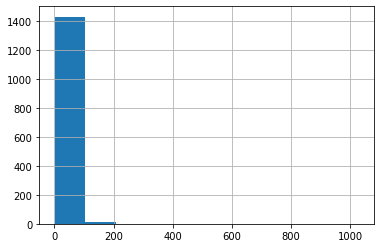

In [261]:
df_solar_alt = df_solar[df_solar['capacity_mw'].notna()]
df_solar_alt['capacity_mw'].value_counts().hist(bins=10)
print(df_solar_alt[df_solar_alt['capacity_mw'] < 20]['capacity_mw'].count())
print(df_solar_alt.loc[(df_solar_alt['capacity_mw'] >= 20) & (df_solar_alt['capacity_mw'] < 100)]['capacity_mw'].count())


<AxesSubplot:>

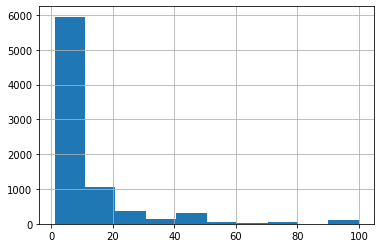

In [262]:

# df_solar_alt.loc[df_solar_alt['capacity_mw'] == (df_solar_alt['capacity_mw'].value_counts()>20)]
# indexes = df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()>20).index
# df_solar_alt['capacity_mw'].value_counts().values>20
# df_solar_alt.loc[indexes]['capacity_mw']
# df_solar_alt[df_solar_alt['capacity_mw'] == 145]
# df_solar_alt[df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()[df_solar_alt['capacity_mw'].value_counts()>20].index)].capacity_mw
df_solar_alt_more_than_20 = df_solar_alt[df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()[df_solar_alt['capacity_mw'].value_counts()>20].index)]
df_solar_alt_more_than_20['capacity_mw'].hist()

In [263]:
# utils.calculate_feature_mean_std(df_solar)

In [264]:
# columns_delete = df_solar.columns.str.contains('WS') | df_solar.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2013') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') |  df_solar.columns.str.contains('ANN') |  df_solar.columns.str.contains('LW') |  df_solar.columns.str.contains('WS10') | df_solar.columns.str.contains('MAX')
# columns_delete = df_solar.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2013') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') 
columns_delete = df_solar.columns.str.contains('generation_gwh_2013') | df_solar.columns.str.contains('estimated_generation_gwh_2013') | df_solar.columns.str.contains('WS') | df_solar.columns.str.contains('name') | df_solar.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') 
# df_solar_2 = df_solar_alt_more_than_20.loc[:,~columns_delete]
df_solar_2 = df_solar_alt.loc[:,~columns_delete]

In [265]:
df_solar_2.columns

Index(['ANN_ALLSKY_SFC_LW_DWN_2013', 'ANN_ALLSKY_SFC_LW_UP_2013',
       'ANN_ALLSKY_SFC_SW_DIFF_2013', 'ANN_ALLSKY_SFC_SW_DNI_2013',
       'ANN_ALLSKY_SFC_SW_DWN_2013', 'ANN_ALLSKY_SFC_SW_UP_2013',
       'ANN_ALLSKY_SFC_SW_UP_MAX_2013', 'ANN_CLRSKY_SFC_SW_DIFF_2013',
       'ANN_CLRSKY_SFC_SW_DNI_2013', 'ANN_CLRSKY_SFC_SW_DWN_2013',
       'ANN_CLRSKY_SFC_SW_UP_2013', 'ANN_T2M_2013',
       'autumn_ALLSKY_SFC_LW_DWN_2013', 'autumn_ALLSKY_SFC_LW_UP_2013',
       'autumn_ALLSKY_SFC_SW_DIFF_2013', 'autumn_ALLSKY_SFC_SW_DNI_2013',
       'autumn_ALLSKY_SFC_SW_DWN_2013', 'autumn_ALLSKY_SFC_SW_UP_2013',
       'autumn_ALLSKY_SFC_SW_UP_MAX_2013', 'autumn_CLRSKY_SFC_SW_DIFF_2013',
       'autumn_CLRSKY_SFC_SW_DNI_2013', 'autumn_CLRSKY_SFC_SW_DWN_2013',
       'autumn_CLRSKY_SFC_SW_UP_2013', 'autumn_T2M_2013',
       'spring_ALLSKY_SFC_LW_DWN_2013', 'spring_ALLSKY_SFC_LW_UP_2013',
       'spring_ALLSKY_SFC_SW_DIFF_2013', 'spring_ALLSKY_SFC_SW_DNI_2013',
       'spring_ALLSKY_SFC_SW_DWN_2013'

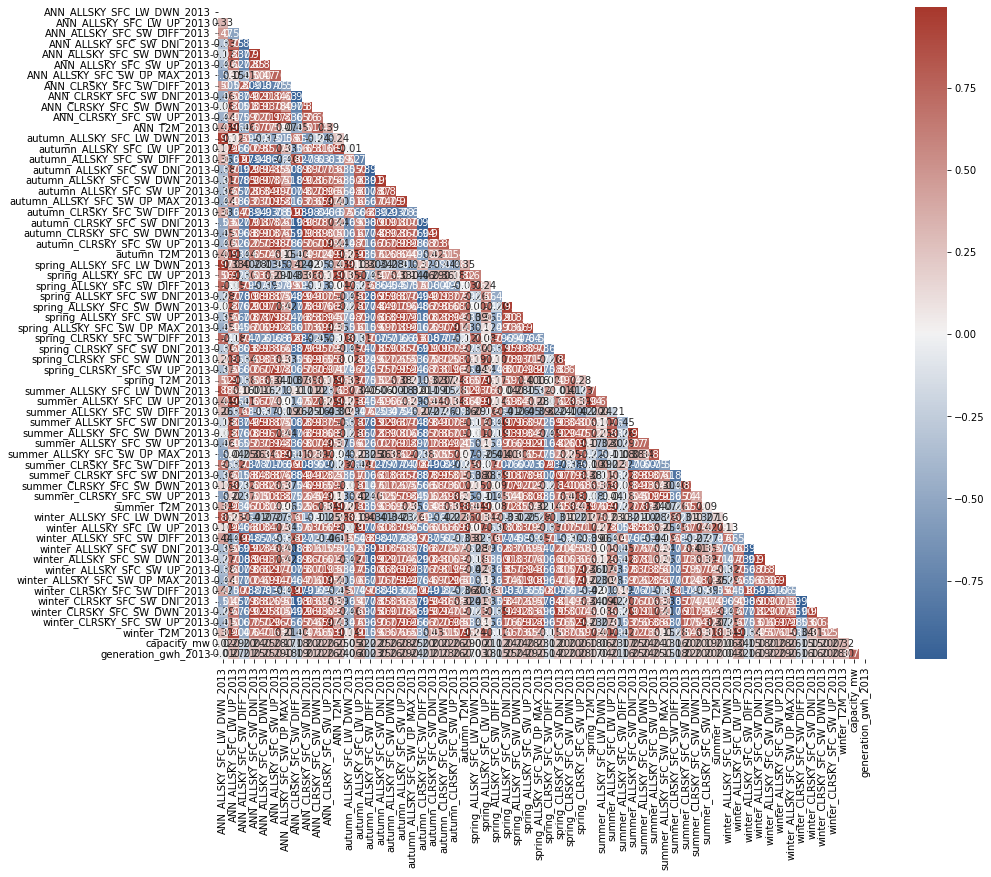

In [157]:
utils.correlation_matrix(df_solar_2)

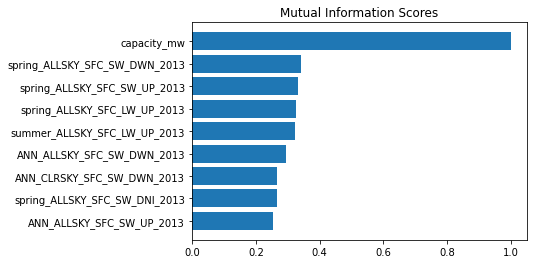

In [295]:
from matplotlib.pyplot import xlabel


# plt.bar(df_solar_2.corr().abs().unstack()['capacity_mw'].sort_values(ascending=False), height=df_solar_2.columns)
corr_matrix = df_solar_2.corr().abs()



target_correlations = corr_matrix.unstack()['capacity_mw'].sort_values(ascending=False)
# target_correlations = corr_matrix.unstack()['generation_gwh_2013'].sort_values(ascending=False)
target_correlations[target_correlations > .20]
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_mi_scores(target_correlations[target_correlations > .20])

/tmp/ipykernel_258/2127776053.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_solar_2.drop(columns=to_drop, inplace=True)


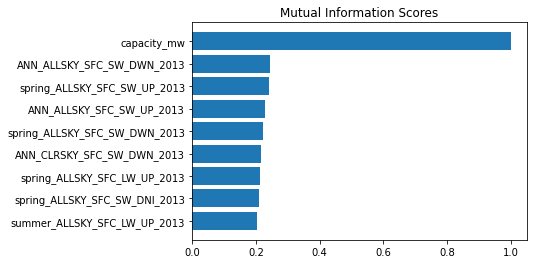

In [267]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df_solar_2.drop(columns=to_drop, inplace=True)

corr_matrix = df_solar_2.corr().abs()



target_correlations = corr_matrix.unstack()['capacity_mw'].sort_values(ascending=False)
# target_correlations = corr_matrix.unstack()['generation_gwh_2013'].sort_values(ascending=False)
target_correlations[target_correlations > .20]
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_mi_scores(target_correlations[target_correlations > .20])

In [296]:
df_solar_2 = df_solar_2[target_correlations[target_correlations > .20].index]
df_solar_2

capacity_mw  spring_ALLSKY_SFC_SW_DWN_2013  \
index                                               
1             10.0                       7.643333   
2             10.0                       7.643333   
17            20.0                       4.630000   
18            20.0                       7.130000   
20            20.0                       7.050000   
...            ...                            ...   
34790         30.0                       5.293333   
34795         49.0                       5.056667   
34796         10.0                       4.653333   
34894         48.0                       5.160000   
34921         47.5                       5.543333   

       spring_ALLSKY_SFC_SW_UP_2013  spring_ALLSKY_SFC_LW_UP_2013  \
index                                                               
1                          1.853333                     11.433333   
2                          1.853333                     11.433333   
17                         1.660000                     10.206667   
18                         1.763333                     10.370000   
20                         1.666667                      9.986667   
...                             ...                           ...   
34790                      0.546667                     10.700000   
34795                      0.590000                     11.123333   
34796                      0.573333                     10.470000   
34894                      0.363333                     11.206667   
34921                      0.770000                      9.903333   

       summer_ALLSKY_SFC_LW_UP_2013  ANN_ALLSKY_SFC_SW_DWN_2013  \
index                                                             
1                         11.990000                        6.05   
2                         11.990000                        6.05   
17                         9.613333                        6.15   
18                        11.400000                        5.21   
20                        11.196667                        5.34   
...                             ...                         ...   
34790                     10.483333                        4.68   
34795                     10.836667                        4.98   
34796                     10.436667                        3.76   
34894                     11.173333                        4.00   
34921                     10.306667                        5.87   

       ANN_CLRSKY_SFC_SW_DWN_2013  spring_ALLSKY_SFC_SW_DNI_2013  \
index                                                              
1                            6.37                       7.393333   
2                            6.37                       7.393333   
17                           6.41                       5.876667   
18                           5.96                       6.830000   
20                           6.18                       7.226667   
...                           ...                            ...   
34790                        6.80                       3.583333   
34795                        6.65                       3.183333   
34796                        6.01                       2.593333   
34894                        6.37                       3.766667   
34921                        6.95                       7.356667   

       ANN_ALLSKY_SFC_SW_UP_2013  
index                             
1                           1.50  
2                           1.50  
17                          2.19  
18                          1.36  
20                          1.29  
...                          ...  
34790                       0.54  
34795                       0.60  
34796                       0.45  
34894                       0.30  
34921                       0.87  

[10309 rows x 9 columns]

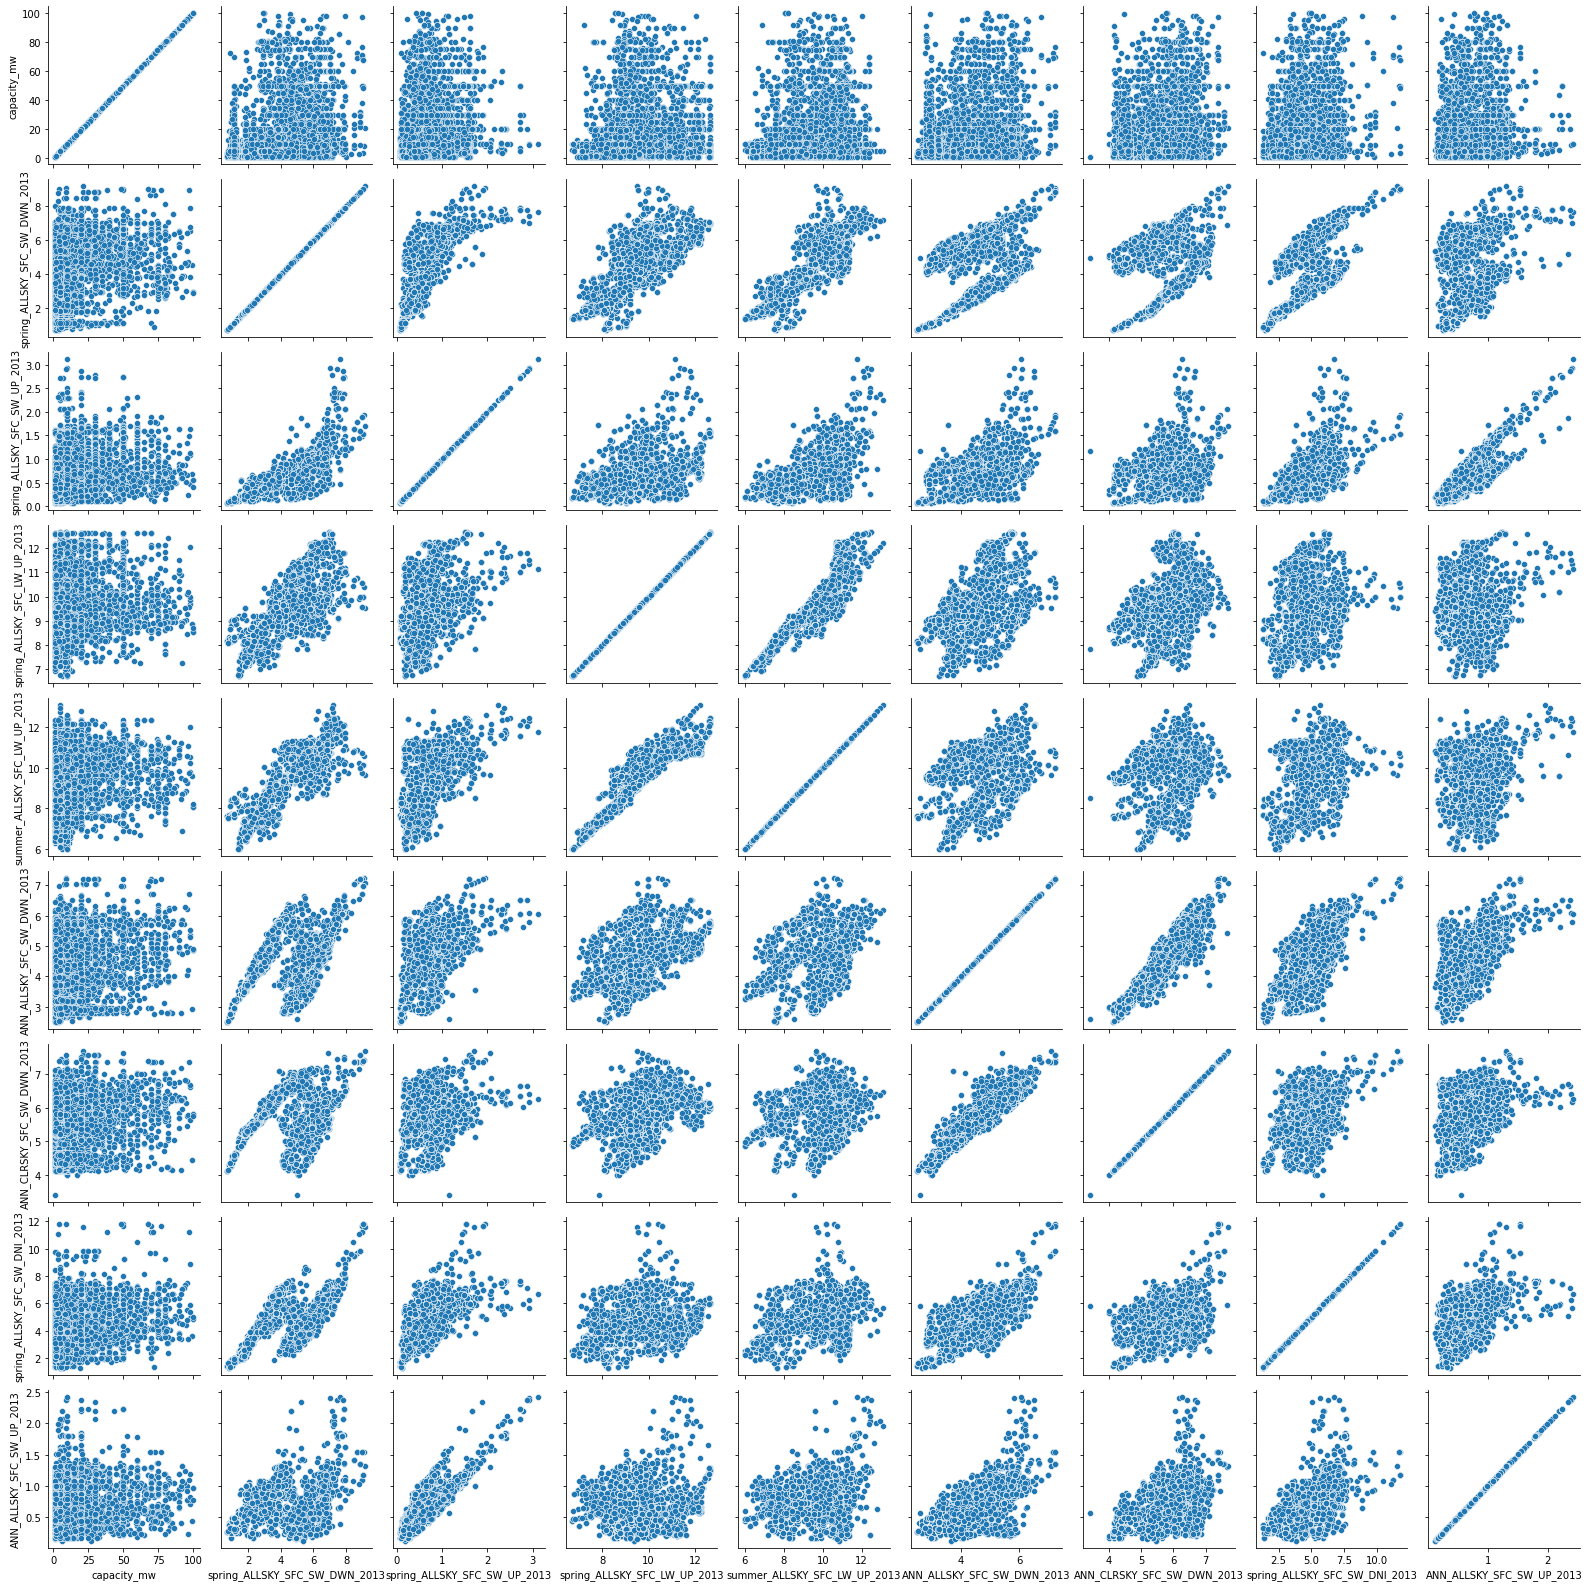

In [297]:
g = sns.PairGrid(df_solar_2)
g.map(sns.scatterplot)

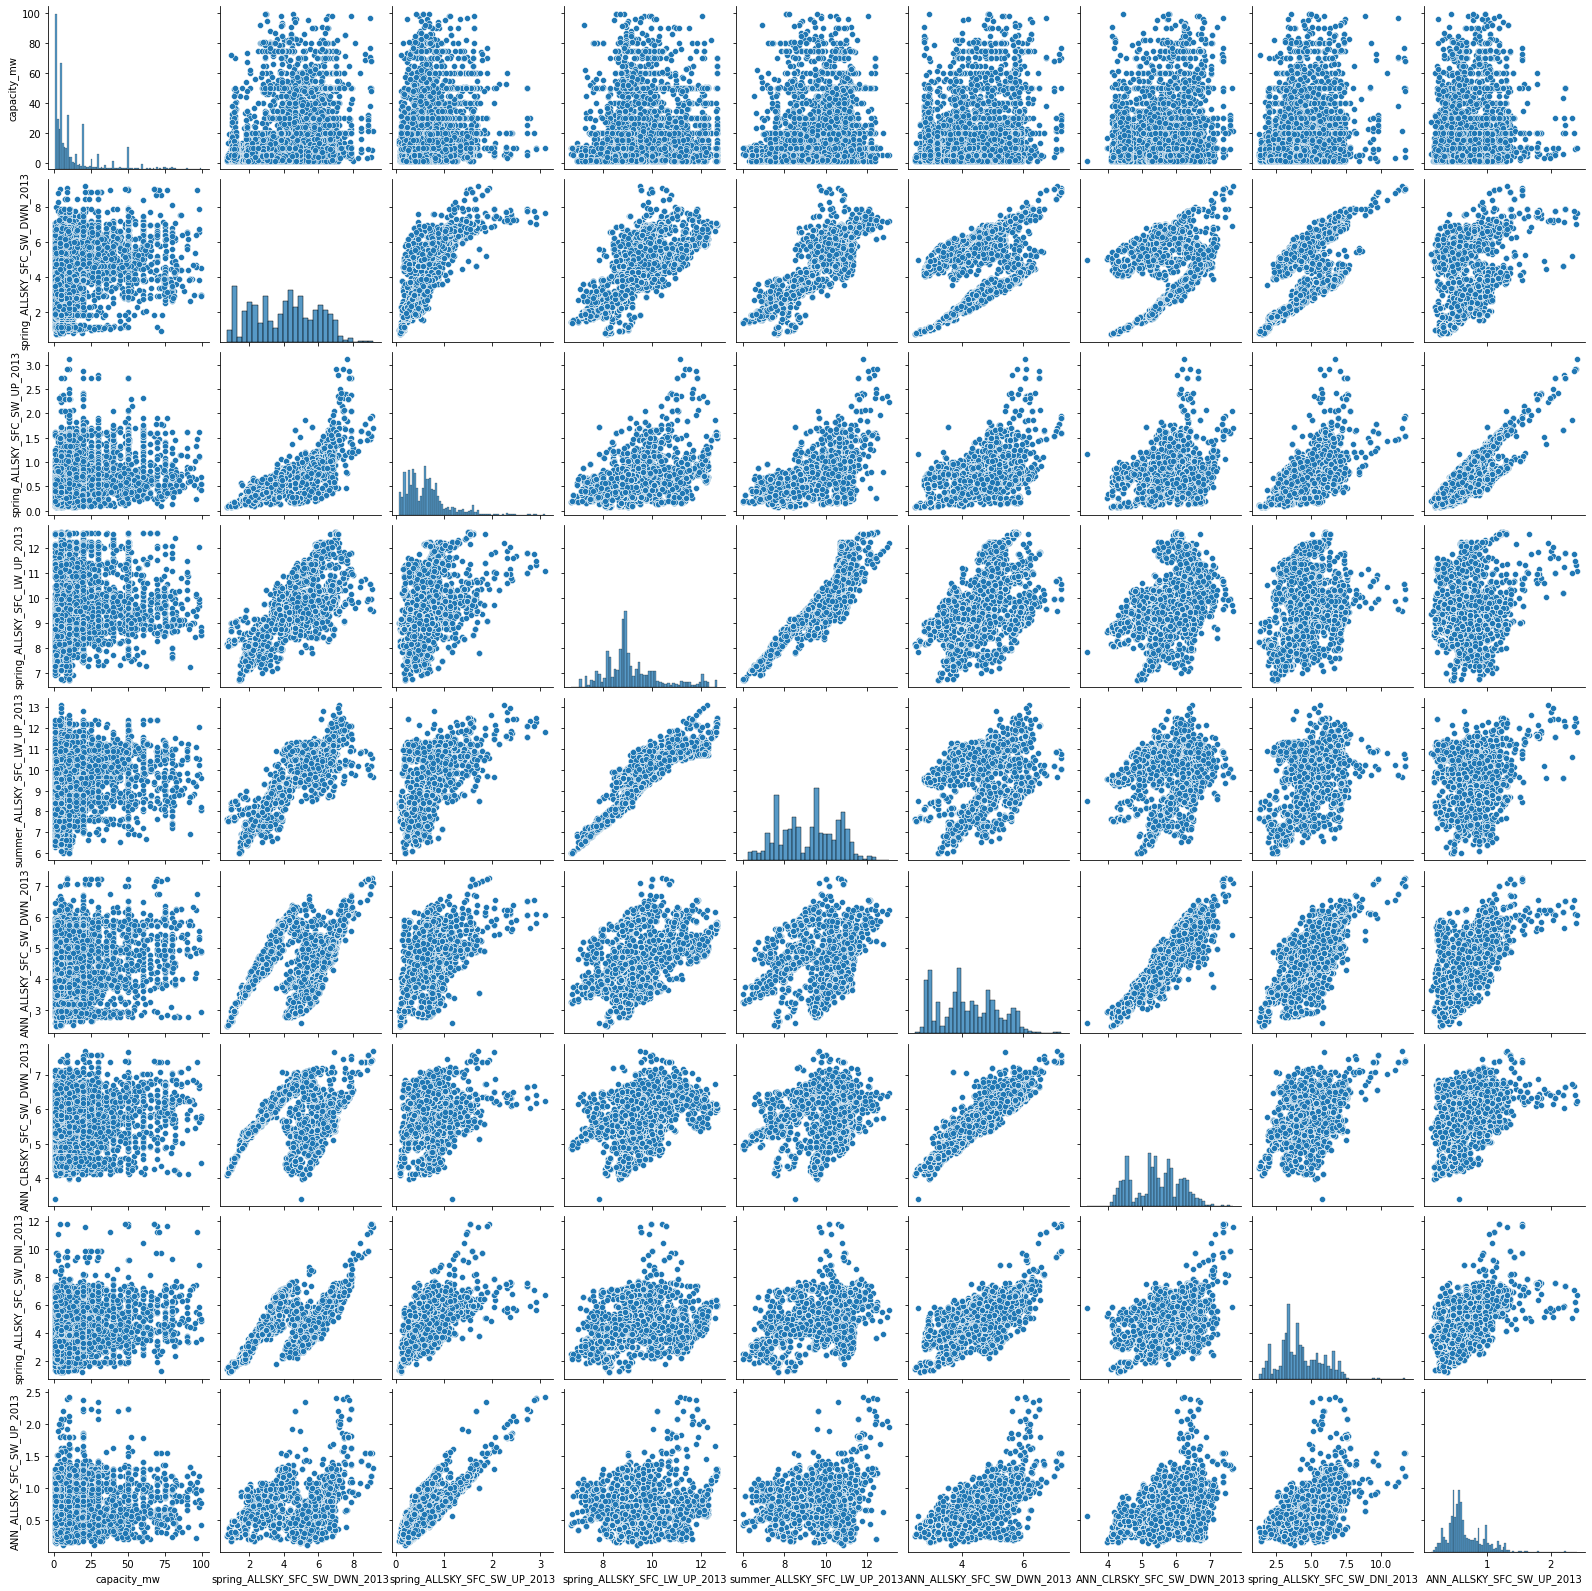

In [298]:
sns.pairplot(df_solar_2)

In [369]:
category = pd.cut(df_solar_2['capacity_mw'], 30).cat.codes.rename('category')
df_solar_3 = pd.concat([df_solar_2, category], axis=1)

In [370]:
category.value_counts()

0     3611
1     2315
2     1301
5      770
3      419
14     353
4      318
8      261
7      176
11     129
6      121
17      74
10      69
22      55
9       48
20      41
13      35
23      29
16      28
15      28
12      27
19      20
24      17
27      14
21      11
18      11
29      10
25       9
28       7
26       2
Name: category, dtype: int64

<AxesSubplot:>

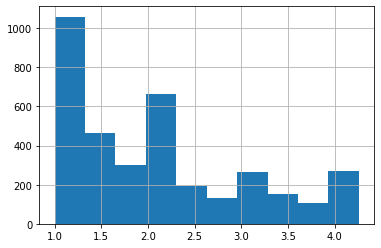

In [371]:
df_solar_3.loc[df_solar_3['category'] == 0]['capacity_mw'].hist()

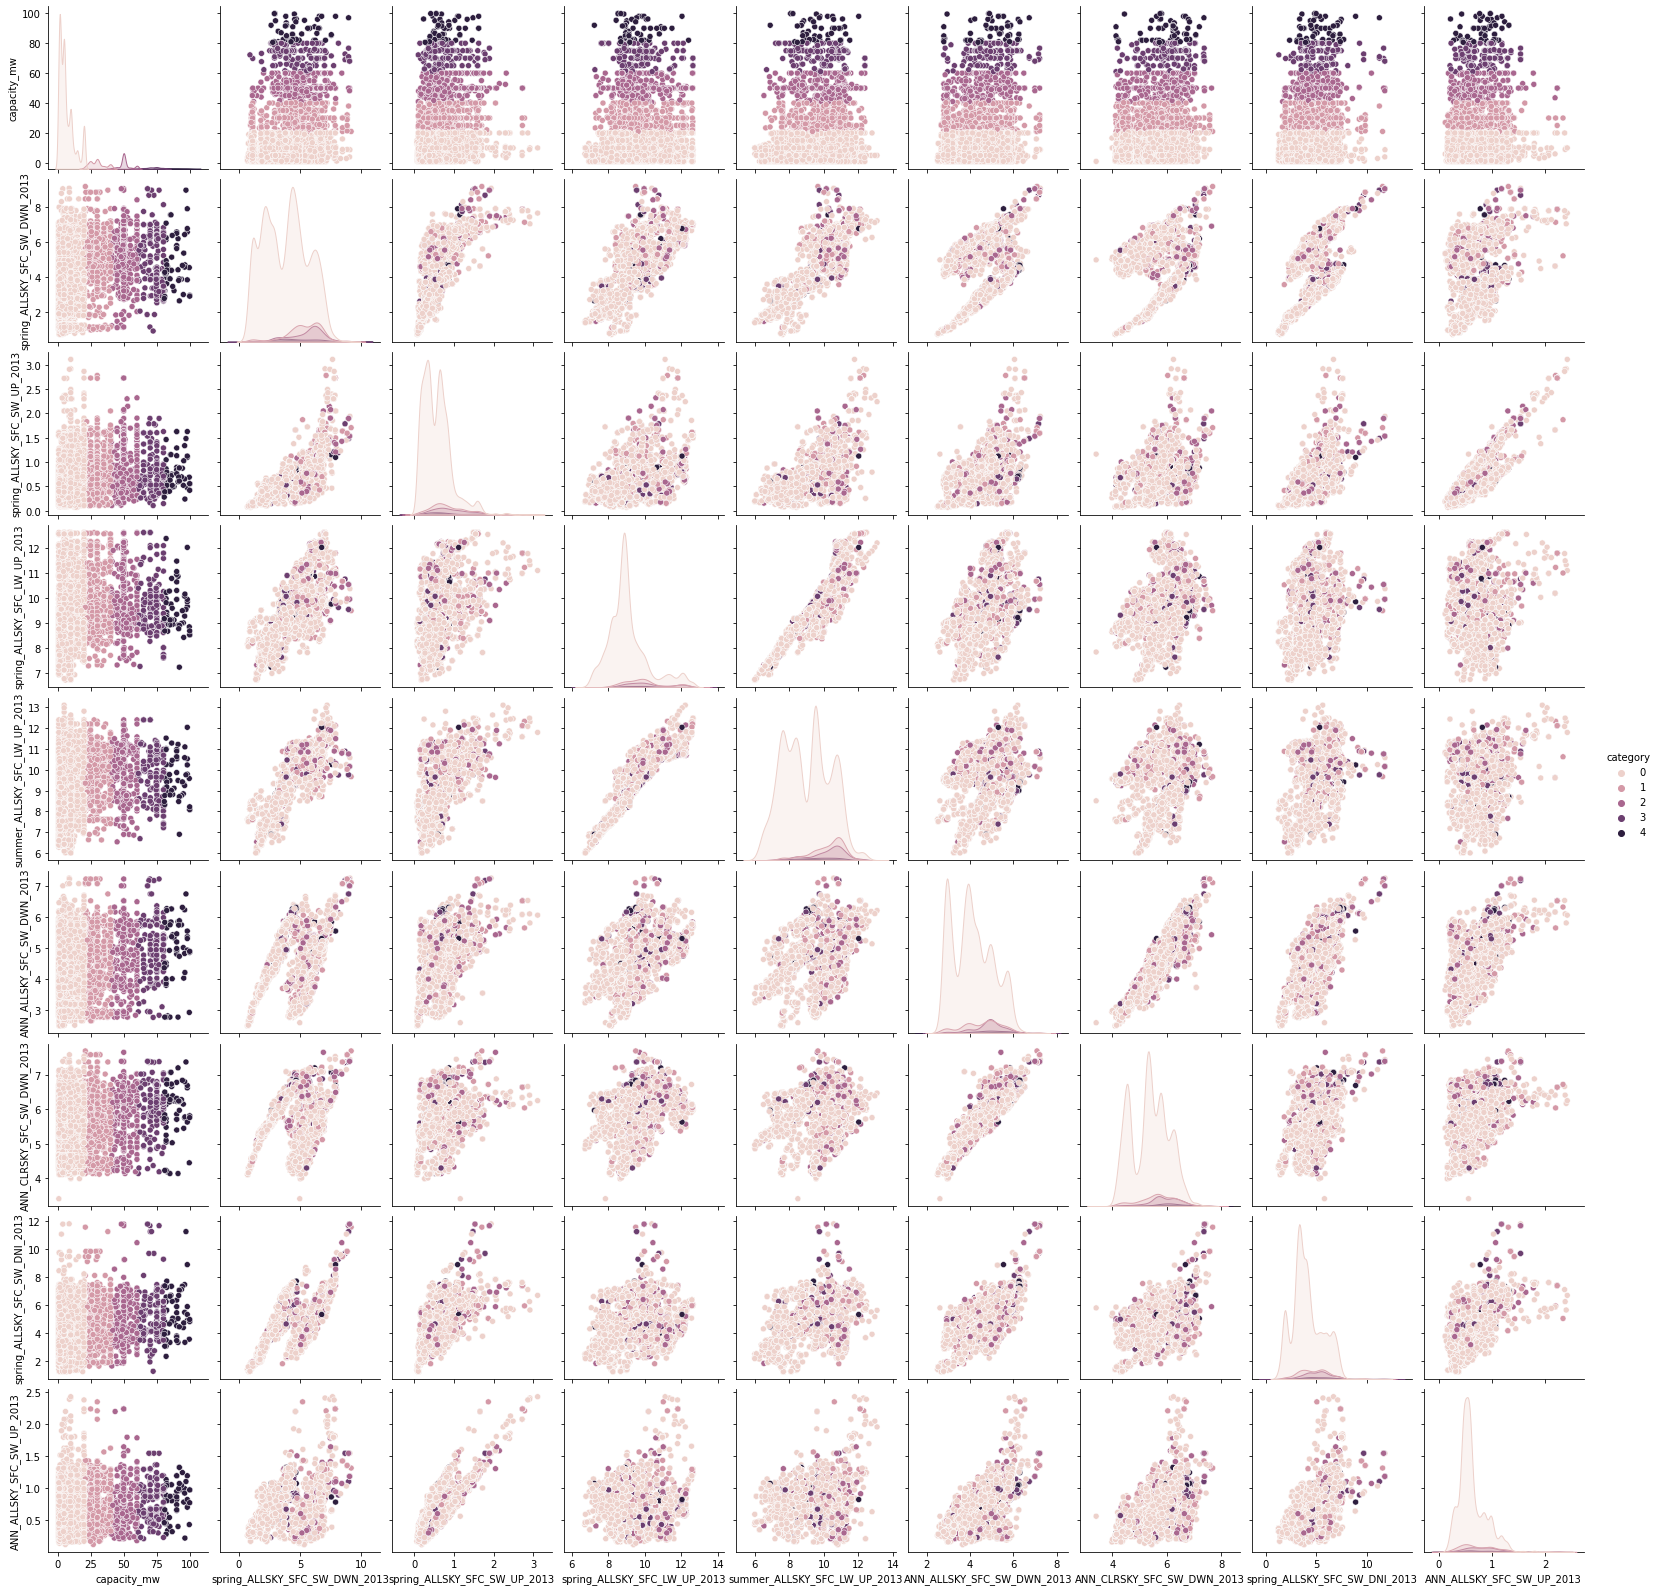

In [304]:
sns.pairplot(df_solar_3, hue='category')

<AxesSubplot:xlabel='capacity_mw', ylabel='generation_gwh_2013'>

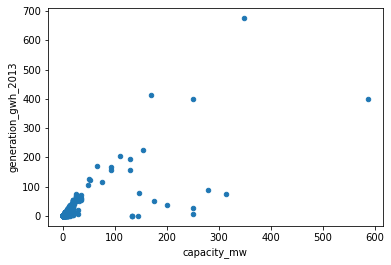

In [165]:
df_solar_2.plot.scatter(x='capacity_mw', y='generation_gwh_2013')

In [166]:
df_solar_2['generation_gwh_2013'].isna().sum()

0

In [167]:
# sns.pairplot(df_solar_2, hue="capacity_mw", height=2.5)

<AxesSubplot:>

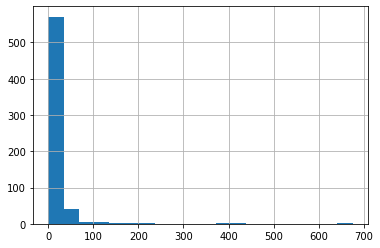

In [168]:
df_solar_2['generation_gwh_2013'].hist(bins=20)

541

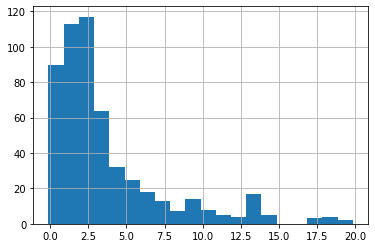

In [57]:
df_solar_2[df_solar_2['generation_gwh_2013'] < 20]['generation_gwh_2013'].hist(bins=20)
df_solar_2[df_solar_2['generation_gwh_2013'] < 20]['generation_gwh_2013'].count()

76

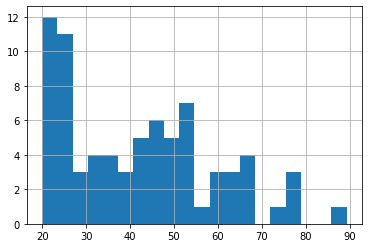

In [76]:
df_solar_2.loc[(df_solar_2['generation_gwh_2013'] >= 20) & (df_solar_2['generation_gwh_2013'] < 100)]['generation_gwh_2013'].hist(bins=20)
df_solar_2.loc[(df_solar_2['generation_gwh_2013'] >= 20) & (df_solar_2['generation_gwh_2013'] < 100)]['generation_gwh_2013'].count()

14

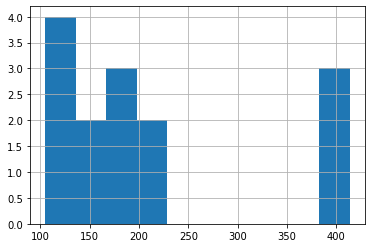

In [77]:
# df_solar_2[df_solar_2['generation_gwh_2013'] > 100]['generation_gwh_2013'].hist(bins=20)
# df_solar_2[df_solar_2['generation_gwh_2013'] > 100]['generation_gwh_2013'].count()
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 100) & (df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].hist()
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 100) & (df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].count()

In [78]:
df_solar_2[(df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].count()

632

In [83]:
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)]['generation_gwh_2013'].count()

Int64Index([24873], dtype='int64', name='index')

In [87]:
df_solar_2.drop(df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)].index, inplace=True)

In [88]:
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)]['generation_gwh_2013'].count()

0

In [89]:
a = df_solar_2[(df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].count()
b = df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)]['generation_gwh_2013'].count()
f'{np.round(b/(a + b) * 100,2)}%'

'0.0%'

In [294]:
# df_solar_2 = df_solar_2[(df_solar_2['capacity_mw'] < 500)].copy()
df_solar_2 = df_solar_2[(df_solar_2['capacity_mw'] < 100)].copy()

In [17]:
# remove high values???
df_solar_2['capacity_mw'].sort_values(ascending= False)

index
20159    99.8
20910    99.8
20460    99.8
20380    99.8
1064     99.5
         ... 
16391     1.0
9787      1.0
32683     1.0
32684     1.0
32196     1.0
Name: capacity_mw, Length: 10316, dtype: float64

In [18]:
# df_solar.loc[18177, ["latitude", "longitude", "capacity_mw"]]

In [372]:
X = df_solar_3.drop(columns=['capacity_mw'])
# X = df_solar_2[['capacity_mw']]
y = df_solar_3['capacity_mw']

In [356]:
y.describe()

count    10309.000000
mean        12.268226
std         15.897004
min          1.000000
25%          2.500000
50%          5.200000
75%         15.000000
max         99.800000
Name: capacity_mw, dtype: float64

In [111]:
counted = y.value_counts().sort_values(ascending=False)
counted.iloc[:3]#filter by value dataframe

0.000    14
1.683     2
1.822     2
Name: generation_gwh_2013, dtype: int64

In [373]:
X = X.reindex(sorted(X.columns), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 0)

# DECISION TREE REGRESSOR

In [374]:

# Define model. Specify a number for random_state to ensure same results each run
tree_model = DecisionTreeRegressor(random_state=1)

# Fit model
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [375]:
y_pred = tree_model.predict(X_test)

In [376]:

print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

0.6506807137639808
0.8720555113110818


In [377]:
tree_model.score(X_test, y_test)

0.9968479818100072

(array([[1447.,  289.,  108.,   42.,   92.,   26.,   22.,   26.,    5.,
            5.],
        [1447.,  289.,  108.,   42.,   92.,   26.,   22.,   26.,    5.,
            5.]]),
 array([ 1.  , 10.88, 20.76, 30.64, 40.52, 50.4 , 60.28, 70.16, 80.04,
        89.92, 99.8 ]),
 <a list of 2 BarContainer objects>)

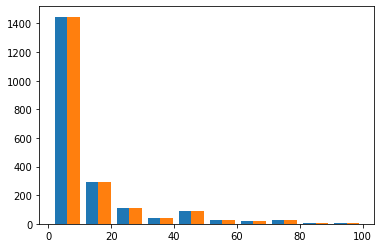

In [378]:
plt.hist([y_test, y_pred])

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

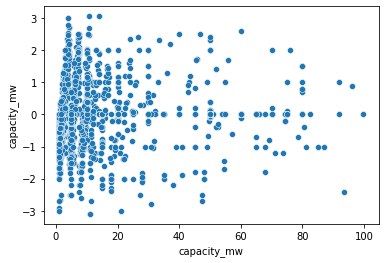

In [379]:
residuals = y_test - y_pred
sns.scatterplot(y_test, residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

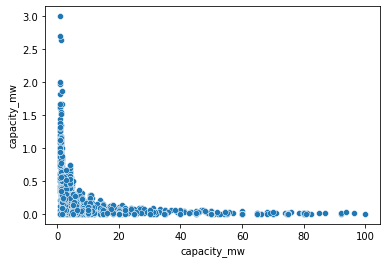

In [380]:
ap_residuals = np.abs(residuals) / y_test

sns.scatterplot(y_test, ap_residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

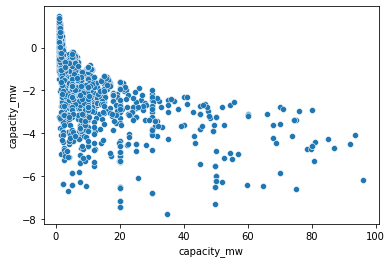

In [366]:
lap_residuals = np.log(ap_residuals)
sns.scatterplot(y_test, lap_residuals)

<BarContainer object of 2062 artists>

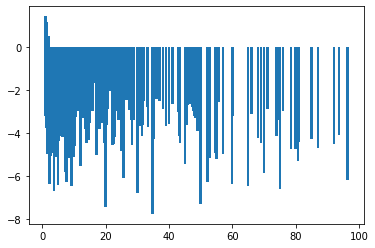

In [367]:
plt.bar(y_test, lap_residuals)

ValueError: supplied range of [-inf, 1.6486586255873816] is not finite

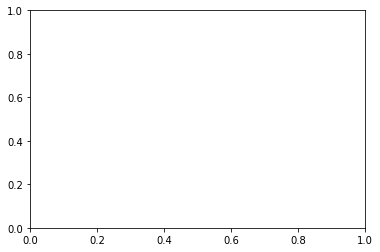

In [342]:
plt.hist(lap_residuals, bins=100, density=1, histtype='step', cumulative=True)

# RANDOM FOREST REGRESSOR

In [343]:
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

1.2608055345389884


In [344]:
rf_model.score(X_test, y_test)

0.9898574953005993

(array([[1447.,  289.,  108.,   42.,   92.,   26.,   22.,   26.,    5.,
            5.],
        [1475.,  261.,  111.,   39.,   91.,   27.,   19.,   29.,    5.,
            5.]]),
 array([ 1.  , 10.88, 20.76, 30.64, 40.52, 50.4 , 60.28, 70.16, 80.04,
        89.92, 99.8 ]),
 <a list of 2 BarContainer objects>)

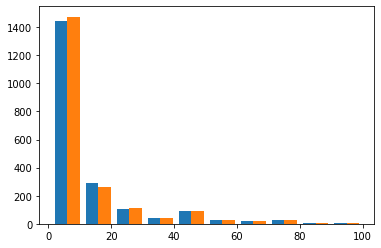

In [345]:
plt.hist([y_test, y_pred])

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

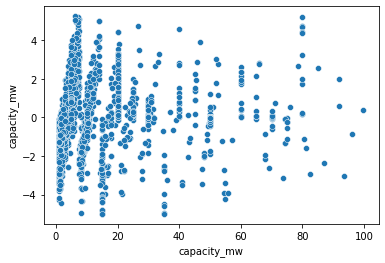

In [346]:
residuals = y_test - y_pred
ap_residuals = np.abs(residuals) / y_test
lap_residuals = np.log(ap_residuals)

sns.scatterplot(y_test, residuals)


/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

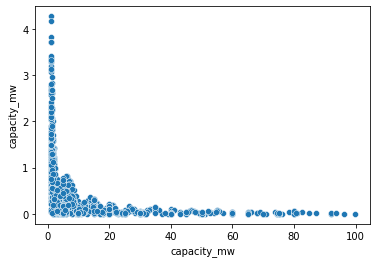

In [347]:

sns.scatterplot(y_test, ap_residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

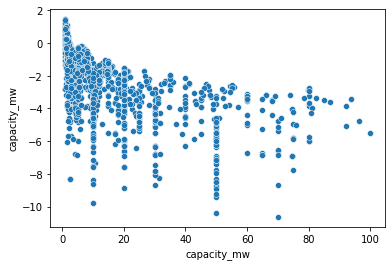

In [348]:

sns.scatterplot(y_test, lap_residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/matplotlib/transforms.py:2052: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/matplotlib/transforms.py:396: RuntimeWarning: invalid value encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


<BarContainer object of 2062 artists>

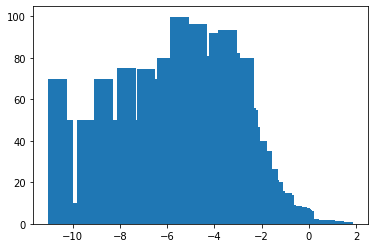

In [349]:
plt.bar(lap_residuals,y_test)

ValueError: supplied range of [-8.046314429606786, inf] is not finite

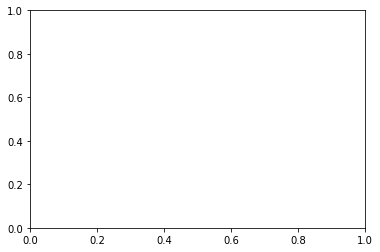

In [87]:
plt.hist(lap_residuals, bins=100, density=1, histtype='step', cumulative=True)

# LASSO

In [368]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train,y_train)

ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train,y_train)

linreg_model = LinearRegression()
linreg_model.fit(X_train,y_train)

y_pred = lasso_model.predict(X_test)
print("Lasso")
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(lasso_model.score(X_test, y_test))

y_pred = linreg_model.predict(X_test)
print("Linear Regression")
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(linreg_model.score(X_test, y_test)
)
y_pred = ridge_model.predict(X_test)
print("Ridge")
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(ridge_model.score(X_test, y_test))

Lasso
1.3470100102914144
2.280254300588283
0.9917580900068417
Linear Regression
1.3379964460116842
2.272229390033697
0.9917870958025886
Ridge
1.338048194480891
2.2721399863615646
0.9917874189494493
